In [875]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from uncertainties import ufloat
from uncertainties.umath import cos
from scipy.optimize import curve_fit
from scipy import odr
from scipy.ndimage import gaussian_filter1d
from skimage.restoration import estimate_sigma

# some constants
p_central = 720
f = ufloat(381*10**6,381*10**6*0.01 ) # focal length parabolic mirrors in nm
s_p = ufloat(3.45*10**3,0) # pixel size in nm
beta = ufloat(math.radians(15), 0)
c = ufloat(299792458, 0) # Lichtgeschwindigkeit in m/s
h = ufloat(6.626_070_15e-34, 0)   # J·s (SI-definiert)
e = ufloat(1.602_176_634e-19, 0)  # C = J/eV

In [876]:
# plt data
def plot_image_profiles(x,y, raw_data, title="Raw intensity profiles"):
    plt.figure(figsize=(8, 5))
    plt.plot(x, raw_data)
    plt.plot(x, y)
    plt.xlabel("Pixel number")
    plt.ylabel("Intensity (normalized)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [877]:
# registration and preprocessing of data
# reads in all tif files in a folder and returns a numpyarray in which every image is stored
def load_images(path):
    images = []

    for filename in os.listdir(path):
        if filename.endswith('.tif'):
            filepath = os.path.join(path, filename)
            image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
            images.append(image)

    images = np.array(images)

    return images

# This part takes for each image in the images array a horizontal bandwidth, takes the average  of said bandwidth and writes it into a new array
def convert_into_array(images):
    band_width = 50 # adjust
    vline_height = 600 # adjust

    images_one_line = []
    raw_one_line = []

    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        height, width = gray.shape
        band_start = max(0, vline_height-band_width // 2)
        band_end   = min(height, vline_height+band_width // 2)

        # band extrahieren
        band = gray[band_start:band_end,:]

        # Average pixel values across the horizontal band (to reduce band to one profile)
        values = band.mean(axis=0)

        # Normalize values to range [0, 1]
        values = (values - np.min(values)) / (np.max(values) - np.min(values))
        raw_one_line.append(values)

        # estimate sigma and eliminate gaussian noise
        sigma_est = estimate_sigma(values, channel_axis=None)
        values = gaussian_filter1d(values, sigma=sigma_est)

        images_one_line.append(values)

    images_one_line = np.array(images_one_line)
    raw_one_line = np.array(raw_one_line)

    return images_one_line, raw_one_line

# This part does organisation of the data processed so far

def sort_data(path_images, path_notes, images_one_line, step):
    # collect and clean the filenames
    filenames = sorted([f for f in os.listdir(path_images) if f.lower().endswith(".tif")])
    names = [os.path.splitext(f)[0] for f in filenames]  # "image.bmp" -> "image"

    k_values = np.loadtxt(f'{path_notes}/k-values_1.txt', delimiter=',') if step == "k_lambda" else np.loadtxt(f'{path_notes}/p_cal_2.txt', delimiter=',')
    if step == "balmer":
        k_values = np.loadtxt(f'{path_notes}/balmer_series_2.txt', delimiter=',')
    k_values = k_values[:, 1]

    # build a dict keyed by image name
    img_dic = {
        name: {
            "k_value": float(k),
            "pixel_values": pix         # 1-D array
        }
        for name, k, pix in zip(names, k_values, images_one_line)
    }

    return img_dic

In [878]:
# everything regarding fits
# makes a rough estimate for parameters of gaussian distributions
def initial_guess(x,y):
    A0 = (np.nanmax(y) - np.nanmin(y)) or 1.0
    mu0 = np.nanargmax(y)
    sigma0 = max(len(x) / 10, 1.0)
    C0 = float(np.nanmin(y))
    return A0, mu0, sigma0, C0

def single_gaussian(x, A, mu, sigma, C):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + C

def single_gaussian_fit(x, y, uncertainties=None, p0=None, print=False):
    p0 = [initial_guess(x,y)] if p0 is None else p0
    popt, pcov = curve_fit(single_gaussian, x, y, p0=p0, sigma=uncertainties, absolute_sigma=True)

    if print is True:
        # unpack parameters
        A1, mu1, sigma1, C = popt

        # fitted curve
        fit_y = single_gaussian(x, *popt)

        # plot
        plt.figure(figsize=(7,4))
        plt.scatter(x, y, s=10, label="Data", color="black")

        # plot the individual components
        plt.plot(x, A1*np.exp(-((x - mu1)**2)/(2*sigma1**2))+C, '--', color="blue", label=f"Peak 1: μ={mu1:.2f} px")

        plt.xlabel("Pixel position")
        plt.ylabel("Normalized signal")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return popt

# first calibration step
def k_lambda(beta, k):
    b, k0 = beta
    return b*(k-k0)

def k_lambda_fit(He_values, k_values, k_uncertainties):
    model = odr.Model(k_lambda)
    data = odr.RealData(k_values, He_values, sx=k_uncertainties, sy=None)
    odr_run = odr.ODR(data, model, beta0=[-0.3, 500]).run()
    b_fit, k0_fit = odr_run.beta
    b_err, k0_err = np.sqrt(np.diag(odr_run.cov_beta))

    # Plot
    k_min, k_max = np.min(k_values), np.max(k_values)
    k_fit = np.linspace(k_min - 0.05*(k_max-k_min), k_max + 0.05*(k_max-k_min), 1000)
    lam_fit = b_fit * (k_fit - k0_fit)

    # r2 score
    lam_pred = b_fit * (k_values - k0_fit)
    ss_res = np.sum((He_values - lam_pred)**2)
    ss_tot = np.sum((He_values - np.mean(He_values))**2)
    r_squared = np.abs(1 - ss_res/ss_tot)

    plt.figure(figsize=(7.5,5))
    plt.errorbar(k_values, He_values, xerr=k_uncertainties*10, yerr=None, fmt='o', capsize=3, label='He spectral lines (uncertainty 10x scaled)')
    plt.plot(k_fit, lam_fit, '-', label='Linear regression')

    plt.xlabel('Rotation position k')
    plt.ylabel('Wavelength [nm]')
    plt.title(f'Linear calibration fit wavelength in regards to k (R² = {r_squared:.5f})')
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_lambda_fit.png', dpi=600)
    plt.show()

    # convert to ufloat for error propagation
    b_u   = ufloat(b_fit,  b_err)
    k0_u  = ufloat(k0_fit, k0_err)

    return b_u, k0_u

def p_k(B, k, lambda_0, p0, k0, b):
    return ((lambda_0/b)-k+k0)*B+p0

# second calibration step
# fit through the origin taking into account uncertainties in b and k0
def fit_B_with_b_k0_uncertainties(k,p,p_uncertainty,b_u,k0_u,lambda0,p_central, B0=-12.0):
    y = p - p_central

    k_uncertainty = 1
    b, b_uncertainty   = b_u.n,  b_u.s
    k0, k0_uncertainty = k0_u.n, k0_u.s

    # Build x from nominal b,k0
    x = (lambda0 / b) - k + k0

    # gaussian error propagation
    dx_db = (lambda0 / (b**2)) * b_uncertainty
    sx  = np.sqrt(dx_db**2 + k0_uncertainty**2 + k_uncertainty**2)

    # fit through origin
    model = odr.Model(lambda beta, xdata: beta[0] * xdata)
    data  = odr.RealData(x, y, sx=sx, sy=p_uncertainty)
    out   = odr.ODR(data, model, beta0=[B0]).run()

    B_fit = out.beta[0]
    B_err = np.sqrt(out.cov_beta[0,0])

    y_hat = B_fit * x
    r2 = 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

    return ufloat(B_fit, B_err), r2

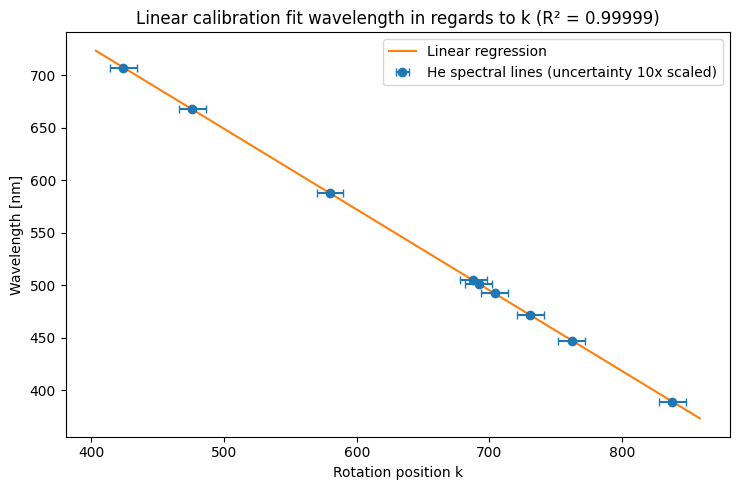

-0.7685+/-0.0033 1344.2+/-3.0


In [879]:
# relation k to lamda
path_k_lamda_Notizen = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Notizen/"
path_k_lamda_Bilder = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Bilder/k_lamda_1"
images_k_lamda = load_images(path_k_lamda_Bilder)
images_one_line_k_lambda, raw_one_line_k_lamda = convert_into_array(images_k_lamda)
img_dic_k_lambda = sort_data(path_k_lamda_Bilder, path_k_lamda_Notizen, images_one_line_k_lambda, "k_lambda")
He_spectrum = np.array([388.8,447.1,471.3,492.1,501.5,504.7,587.5,667.8, 706.5])
k_measured_lamda = np.array([img_dic_k_lambda[name]['k_value'] for name in img_dic_k_lambda])

# sanity check
if len(He_spectrum) != len(k_measured_lamda):
    raise Exception("Zu viele oder zu wenig Linien detektiert :/")

# uncertainties
sigma_k_lambda = np.ones_like(k_measured_lamda) #adjust
sigma_lambda = None

# linear fit for relation, k and lamda
b, k0 = k_lambda_fit(He_spectrum, k_measured_lamda, sigma_k_lambda)
print(b,k0)

-27.4+/-2.5


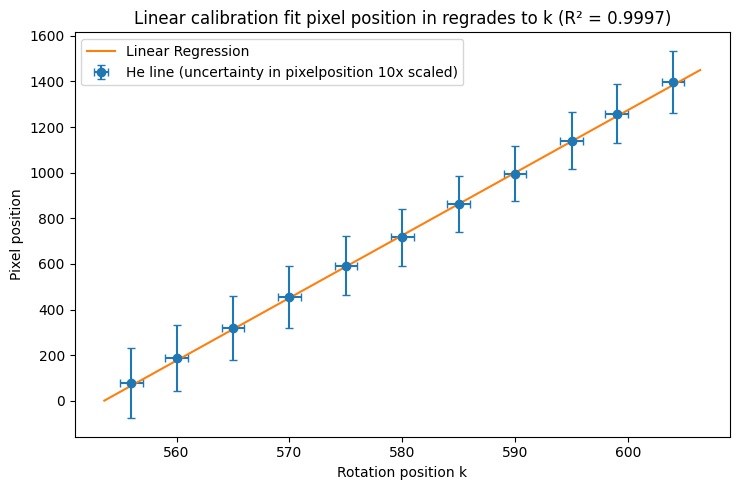

In [880]:
path_p_k_Notizen = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Notizen/"
path_p_k_Bilder = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Bilder/p_cal_2"

images_p_k = load_images(path_p_k_Bilder)
images_one_line_p_k, raw_one_line_p_k = convert_into_array(images_p_k )
img_dic_p_k = sort_data(path_p_k_Bilder, path_p_k_Notizen, images_one_line_p_k, "p_k")

# fit gaussian to intensity profile
fit_results_p_k = {}

for name in img_dic_p_k:
    y = img_dic_p_k[name]["pixel_values"]
    x = np.linspace(0, len(y), len(y))

    # fit
    p_opt = single_gaussian_fit(x, y)

    # Parameter entpacken
    A, mu, sigma, C = p_opt

    # Save results in dic
    fit_results_p_k[name] = {
        "A": A,
        "mu": mu,
        "sigma": sigma,
        "C": C,
    }

p_values = np.array([fit_results_p_k[name]["mu"] for name in img_dic_p_k])
k_measured_p = np.array([img_dic_p_k[name]['k_value'] for name in img_dic_p_k])
sigma_k_p = np.ones_like(k_measured_p)
lambda0 = 587.5

# linear fit for relation, k and px
B, r2_p_k = fit_B_with_b_k0_uncertainties(k_measured_p,p_values,np.abs([fit_results_p_k[name]["sigma"] for name in fit_results_p_k]),b,k0,lambda0,p_central)
print(B)

# plot fit
kmin, kmax = float(np.min(k_measured_p)), float(np.max(k_measured_p))
k_fit = np.linspace(kmin - 0.05*(kmax-kmin), kmax + 0.05*(kmax-kmin), 600)
p_fit = p_k([B.n], k_fit, lambda0, p_central, k0.n, b.n)

plt.figure(figsize=(7.5,5))
plt.errorbar(k_measured_p, p_values, xerr=1, yerr=np.abs([fit_results_p_k[name]["sigma"]*10 for name in fit_results_p_k]), fmt='o', capsize=3, label='He line (uncertainty in pixelposition 10x scaled)')
plt.plot(k_fit, p_fit, '-', label=f'Linear Regression')
plt.xlabel('Rotation position k')
plt.ylabel('Pixel position')
plt.title(f'Linear calibration fit pixel position in regrades to k (R² = {r2_p_k:.4f})')
plt.legend()
plt.tight_layout()
plt.savefig('p_k_fit.png', dpi=600)
plt.show()

In [881]:
# double gauss fit for grid constant
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    g1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    g2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return g1 + g2 + C

def double_fit_gaussian(x,y, uncertainty=None, p0=None):
    # fit
    popt, pcov = curve_fit(double_gaussian, x, y, p0=p0, sigma=uncertainty, absolute_sigma=True)

    # unpack parameters
    A1, mu1, sigma1, A2, mu2, sigma2, C = popt

    # fitted curve
    fit_y = double_gaussian(x, *popt)

    # plot
    plt.figure(figsize=(7,4))
    plt.scatter(x, y, s=10, label="Data", color="black")
    plt.plot(x, fit_y, color="red", label="Double Gaussian fit")

    # plot the individual components
    plt.plot(x, A1*np.exp(-((x - mu1)**2)/(2*sigma1**2))+C, '--', color="blue", label=f"Peak 1: μ={mu1:.2f} px")
    plt.plot(x, A2*np.exp(-((x - mu2)**2)/(2*sigma2**2))+C, '--', color="orange", label=f"Peak 2: μ={mu2:.2f} px")

    plt.xlabel("Pixel position")
    plt.ylabel("Normalized signal")
    plt.legend()
    plt.tight_layout()
    plt.savefig('fit_double_gaussian.png', dpi=600)
    plt.show()

    return mu1, sigma1, mu2, sigma2

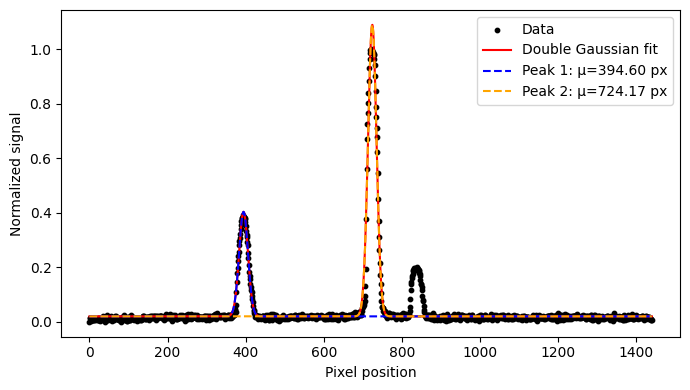

Line spacing: (3.26+/-0.16)e-06 m
Grid constant: (3.07+/-0.15)e+05 lines/m


In [882]:
# calculate grid constant
# read in image
img_d = cv2.imread("C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Bilder/k_lamda_1/Calibration_2025-10-08T16-11-50.936.tif", cv2.IMREAD_UNCHANGED)

band_width = 50 # adjust
vline_height = 600 # adjust
gray = cv2.cvtColor(img_d, cv2.COLOR_BGR2GRAY)

height, width = gray.shape
band_start = max(0, vline_height-band_width // 2)
band_end   = min(height, vline_height+band_width // 2)

# band extrahieren
band = gray[band_start:band_end,:]

# Average pixel values across the horizontal band (to reduce band to one profile)
values_g = band.mean(axis=0)

# Normalize values to range [0, 1]
values_g = (values_g - np.min(values_g)) / (np.max(values_g) - np.min(values_g))
raw_one_line_g = values_g

# estimate sigma and eliminate gaussian noise
sigma_est = estimate_sigma(values_g, channel_axis=None)
values_g = gaussian_filter1d(values_g, sigma=sigma_est)

# double gaussian fit
mu1, sigma1, mu2, sigma2 = double_fit_gaussian(np.linspace(0, len(values_g), len(values_g)), values_g, None ,[1, 400, 1, 1, 700, 1, 1])


f = ufloat(381*10**6,381*10**6*0.01 ) # focal length parabolic mirrors in nm
s_p = ufloat(3.45*10**3,0) # pixel size in nm
beta = ufloat(math.radians(15), 0)

mu1 = ufloat(mu1, sigma1)
mu2 = ufloat(mu2, sigma2)

lambda_1 = ufloat(492.1*10**(-9),0)
lambda_2 = ufloat(501.5*10**(-9),0)
d = (lambda_2- lambda_1)*f/((mu2-mu1)*s_p*cos(beta))
print(f"Line spacing: {d} m")
g = 1/d
print(f"Grid constant: {g} lines/m")

In [883]:
# calibrated wavelength function
def lambda_cal(b, k0, p0, B, k, p):
    return b*((k-k0)+(p-p0)/B)

In [884]:
# calculate balmer series
path_balmer_Notizen = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Notizen/"
path_balmer_Bilder = "C:/Users/Lorenz/Documents/Datenanalyse/P1/Basic_Spectroscopy_1/Bilder/balmer_serie_2"

images_balmer = load_images(path_balmer_Bilder)
images_one_line_balmer, raw_one_line_balmer = convert_into_array(images_balmer)
img_dic_balmer = sort_data(path_balmer_Bilder, path_balmer_Notizen, images_one_line_balmer, "balmer")

# fit gaussian to intensity profile
fit_results_balmer = {}

for name in img_dic_balmer:
    y = img_dic_balmer[name]["pixel_values"]
    x = np.linspace(0, len(y), len(y))

    # fit
    if name != "Calibration_2025-10-08T17-21-13.276":
        p_opt = single_gaussian_fit(x, y, None, [1, 740, 1, 1])
    else:
        p_opt = single_gaussian_fit(x, y, None, [1, 720, 1, 1])

    # Parameter entpacken
    A, mu, sigma, C = p_opt

    # Save results in dic
    fit_results_balmer[name] = {
        "A": A,
        "mu": mu,
        "sigma": sigma,
        "C": C,
    }

p_values_balmer = np.array([fit_results_balmer[name]["mu"] for name in img_dic_balmer])
p_values_uncertainty_balmer = np.array([fit_results_balmer[name]["sigma"] for name in img_dic_balmer])
k_values_balmer = np.array([img_dic_balmer[name]['k_value'] for name in img_dic_balmer])
p0 = ufloat(p_central,0)

lambda_measured = np.array([lambda_cal(b, k0, p0, B, ufloat(k_values_balmer[i], 1), ufloat(p_values_balmer[i], p_values_uncertainty_balmer[i])) for i in range(len(k_values_balmer))])

print(lambda_measured)

[434.3472846023669+/-3.0733409540674463
 464.2372825310136+/-3.157610670907946
 486.688995989592+/-3.2198983548178406
 656.4439990799677+/-3.731656391641866]


In [885]:
# calculate Rydberg frequency
lambda_balmer = np.array([lambda_measured[0],lambda_measured[2], lambda_measured[3]])
n = [5,4,3]
lambda_balmer_val = np.array([lambda_nm * 1e-9 for lambda_nm in lambda_balmer]) # convert to meter
n_delta = np.array([1/4-1/(i**2) for i in n])

R_vals = np.array([(1/lam) / d for lam, d in zip(lambda_balmer_val, n_delta)])
R_mean = np.mean(R_vals)

Rf = c*R_vals
Rf_mean = np.mean(Rf)

print("Rydberg-Frequency separate [Hz]:")
for i, R in enumerate(Rf, start=1):
    print(f"Rf_{i} = {R}")

print("mean Rydberg-Frequenz ν_R [Hz]:", Rf_mean)

Rydberg-Frequency separate [Hz]:
Rf_1 = (3.287+/-0.023)e+15
Rf_2 = (3.285+/-0.022)e+15
Rf_3 = (3.288+/-0.019)e+15
mean Rydberg-Frequenz ν_R [Hz]: (3.287+/-0.021)e+15


In [886]:
# berechnet die Reihengrenze
f_limit = Rf_mean * 0.25
lambda_limit = c / f_limit
lambda_limit_nm = lambda_limit * 1e9 # convert to nm

print("Balmer-Reihengrenz:")
print(f"f_limit = {f_limit:.6e} Hz")
print(f"λ_limit = {lambda_limit_nm:.3f} nm")

Balmer-Reihengrenz:
f_limit = (8.216798+/-0.051791)e+14 Hz
λ_limit = 364.853+/-2.300 nm


In [887]:
# berechnet Ionisierungsenergie
E_I_J = h * Rf_mean
E_I_eV = E_I_J / e
print("Ionisierungsenergie:")
print(f"E = {E_I_eV:.4f} eV  (={E_I_J:.6e} J)")

Ionisierungsenergie:
E = 13.5928+/-0.0857 eV  (=(2.177803+/-0.013727)e-18 J)
